## Out Of Distribution Classifier using gpt-3.5-turbo

In [1]:
import pandas as pd
from datasets import  load_dataset
import openai
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from util_functions import compute_metrics, print_eval_metrics, save_metrics
tqdm.pandas()


In [3]:
def ood_classifier_gpt35(text: str) -> str:
    """
    Classifies whether a given text is a movie review or not,
    using Openai's gpt-3.5-turbo model.

    Args:
    text: str
        A text string
    response_text: str
        The prediction
    """
    messages = [
        {"role": "user",
         "content": f""" Assess if the following is a movie review or not and return exactly one word: 
         'yes' if it is a review for movies or any kind of tv show review or film review or cinema review,
         'no' if it is not 
         {text} """}
        ]
    
    response = openai.ChatCompletion.create(
                      model="gpt-3.5-turbo",
                      messages=messages,
                      max_tokens=3,
                      n=1,
                      stop=None,
                      temperature=0.1,
                      request_timeout=4)

    response_text = response.choices[0].message.content.strip().lower()

    return response_text

#### Load Review Datasets

In [4]:
imdb = load_dataset("imdb")
amazon = load_dataset("amazon_polarity", split='test')[:10_000]
yelp = load_dataset("yelp_polarity", split='train')[:10_000]


#### Preprocess Datasets 

In [5]:
df_imdb = pd.concat([pd.DataFrame(imdb['train']),  pd.DataFrame(imdb['train'])], axis=0, ignore_index=True)[:10_000]
df_imdb.loc[:, 'label'] = 1

In [6]:
df_amazon = pd.DataFrame(amazon)
df_amazon['text'] = df_amazon['title'] + '. ' + df_amazon['content']
df_amazon = df_amazon.drop(['title', 'content'], axis=1)
df_amazon.loc[:, 'label'] = 0

In [7]:
df_yelp = pd.DataFrame(yelp)
df_yelp.loc[:, 'label'] = 0

In [ ]:
# Sample 250 examples from each dataset


#### Combine Datasets

In [8]:
test_df = pd.concat([df_imdb, df_amazon, df_yelp], axis=0, ignore_index=True)
test_df

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,1
1,"""I Am Curious: Yellow"" is a risible and preten...",1
2,If only to avoid making this type of film in t...,1
3,This film was probably inspired by Godard's Ma...,1
4,"Oh, brother...after hearing about this ridicul...",1
5,I would put this at the top of my list of film...,1
6,Whoever wrote the screenplay for this movie ob...,1
7,"When I first saw a glimpse of this movie, I qu...",1
8,"Who are these ""They""- the actors? the filmmake...",1
9,This is said to be a personal film for Peter B...,1


In [9]:
test_df.loc[:, 'pred'] = None
test_df

,text,label,pred
0,I rented I AM CURIOUS-YELLOW from my video sto...,1,None
1,"""I Am Curious: Yellow"" is a risible and preten...",1,None
2,If only to avoid making this type of film in t...,1,None
3,This film was probably inspired by Godard's Ma...,1,None
4,"Oh, brother...after hearing about this ridicul...",1,None
5,I would put this at the top of my list of film...,1,None
6,Whoever wrote the screenplay for this movie ob...,1,None
7,"When I first saw a glimpse of this movie, I qu...",1,None
8,"Who are these ""They""- the actors? the filmmake...",1,None
9,This is said to be a personal film for Peter B...,1,None


In [10]:
max_retries = 10
for index, row in tqdm(test_df.iterrows(), total=len(test_df), colour='green'):
    if pd.isnull(row['pred']):
        retries = 0
        while retries < max_retries:
            try:
                test_df.loc[index, 'pred'] = ood_classifier_gpt35(row['text'])
                test_df.to_csv('checkpoints.csv', index=False)
                break
            except Exception as e:
                retries += 1
                print(f"Error processing row {index}, retry {retries}/{max_retries}: {e}")
                if retries == max_retries:
                    print(f"Maximum retries reached for row {index}. Skipping.")
                    break  


  0%|          | 0/40 [00:00<?, ?it/s]

Error processing row 1, retry 1/10: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=4)
Error processing row 1, retry 2/10: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=4)
Error processing row 1, retry 3/10: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=4)
Error processing row 9, retry 1/10: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=4)
Error processing row 10, retry 1/10: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=4)
Error processing row 13, retry 1/10: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=4)
Error processing row 13, retry 2/10: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=4)
Err

In [11]:
test_df

,text,label,pred
0,I rented I AM CURIOUS-YELLOW from my video sto...,1,yes
1,"""I Am Curious: Yellow"" is a risible and preten...",1,yes
2,If only to avoid making this type of film in t...,1,yes
3,This film was probably inspired by Godard's Ma...,1,yes
4,"Oh, brother...after hearing about this ridicul...",1,yes
5,I would put this at the top of my list of film...,1,yes
6,Whoever wrote the screenplay for this movie ob...,1,yes
7,"When I first saw a glimpse of this movie, I qu...",1,yes
8,"Who are these ""They""- the actors? the filmmake...",1,yes
9,This is said to be a personal film for Peter B...,1,yes


#### Transform predictions column and store results in .csv file

In [12]:
test_df.loc[test_df['pred'] == 'no', 'pred'] = 0
test_df.loc[test_df['pred'] == 'yes', 'pred'] = 1
test_df['pred'] = test_df['pred'].astype(np.int64)
test_df.to_csv('predictions_ood.csv', index=True)
print("Stored results.")


Stored results.


In [13]:
test_df

,text,label,pred
0,I rented I AM CURIOUS-YELLOW from my video sto...,1,1
1,"""I Am Curious: Yellow"" is a risible and preten...",1,1
2,If only to avoid making this type of film in t...,1,1
3,This film was probably inspired by Godard's Ma...,1,1
4,"Oh, brother...after hearing about this ridicul...",1,1
5,I would put this at the top of my list of film...,1,1
6,Whoever wrote the screenplay for this movie ob...,1,1
7,"When I first saw a glimpse of this movie, I qu...",1,1
8,"Who are these ""They""- the actors? the filmmake...",1,1
9,This is said to be a personal film for Peter B...,1,1


#### Compute metrics

In [14]:
metrics = compute_metrics(true_labels=test_df['label'].to_list(), 
                          predicted_labels=test_df['pred'].to_list())
print_eval_metrics(metrics)
save_metrics(metrics=metrics, file_name="metrics_ood")

The precision score is:  1.00
The recall score is:  1.00
The f1_score score is:  1.00
The accuracy score is:  1.00
Saved metrics_ood.json!


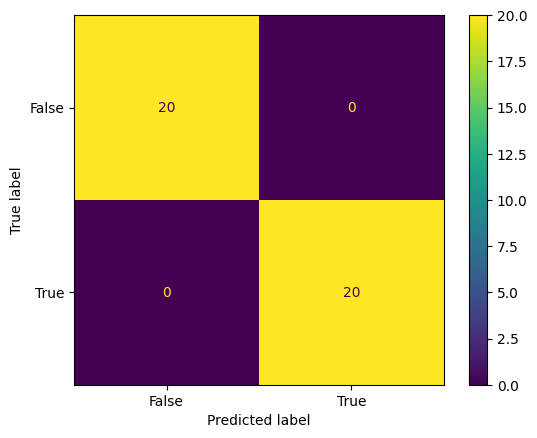

In [15]:
conf_matrix = confusion_matrix(y_true=test_df['label'].values, 
                               y_pred=test_df['pred'].values)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                                    display_labels=[False, True])
cm_display.plot()
plt.show()

In [16]:
errors_df = test_df[test_df['label'] != test_df['pred']]
errors_df.to_csv('errors_ood.csv')